In [1]:
import pandas as pd
import numpy as np
import random
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
# Settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
df = pd.DataFrame(np.random.randint(1,200,size=200), columns=['y'])

In [4]:
df.head()

,y
0,111
1,137
2,67
3,122
4,173


No handles with labels found to put in legend.


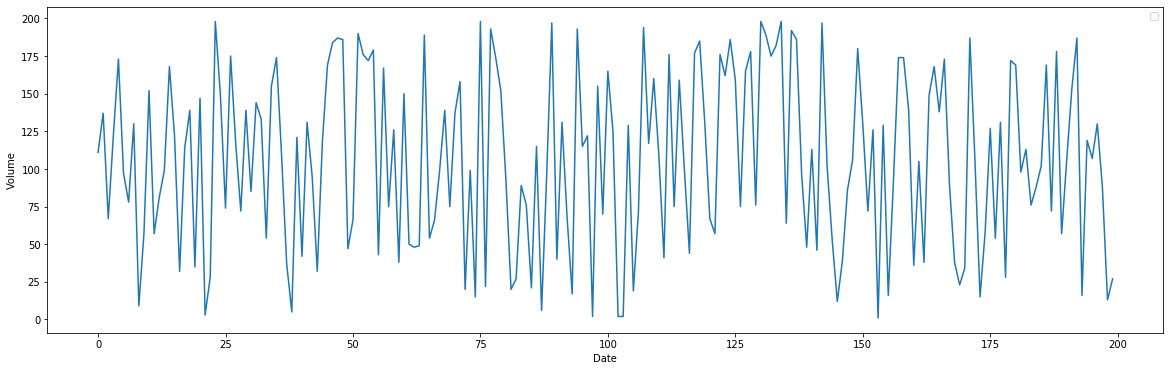

In [5]:
plt.figure(figsize=(20,6))
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Volume')
#plt.xticks(daily_traffic_1['Date'])
plt.legend()
plt.locator_params(nbins=10)
plt.show()

## Time Series Exploration

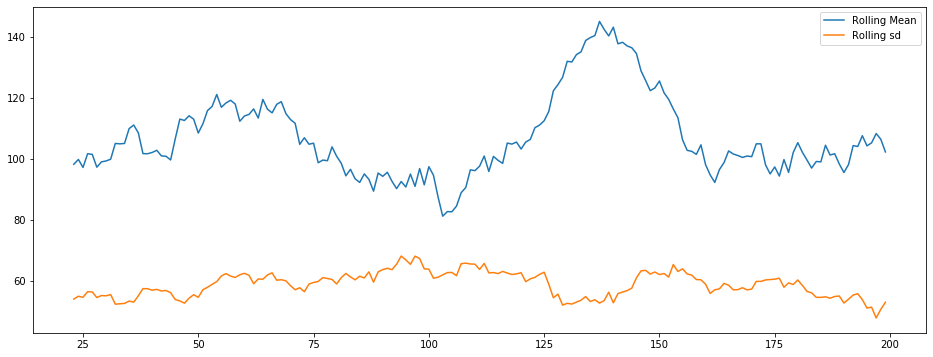

In [6]:
plt.figure(figsize=(16,6))
plt.plot(df.rolling(window=24,center=False).mean(),label='Rolling Mean')
plt.plot(df.rolling(window=24,center=False).std(),label='Rolling sd')
plt.legend()

There is an increasing trend.

### Decomposition

Multiplicative model

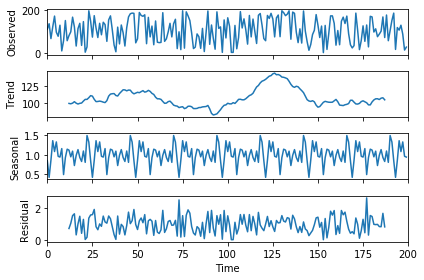

In [7]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df.values,freq=24,model="multiplicative")
fig = res.plot()
fig.show()
#plt.figure(figsize=(100,20))
#plt.plot(res)

Additive Model

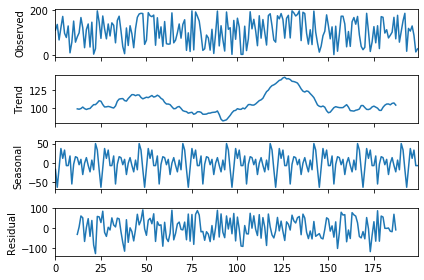

In [8]:
res = sm.tsa.seasonal_decompose(df,freq=24,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

We check for stationarity using ADF test.

In [9]:
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df['y'])

Results of Dickey-Fuller Test:
Test Statistic                -1.377582e+01
p-value                        9.494716e-26
#Lags Used                     0.000000e+00
Number of Observations Used    1.990000e+02
Critical Value (1%)           -3.463645e+00
Critical Value (5%)           -2.876176e+00
Critical Value (10%)          -2.574572e+00
dtype: float64


In [10]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

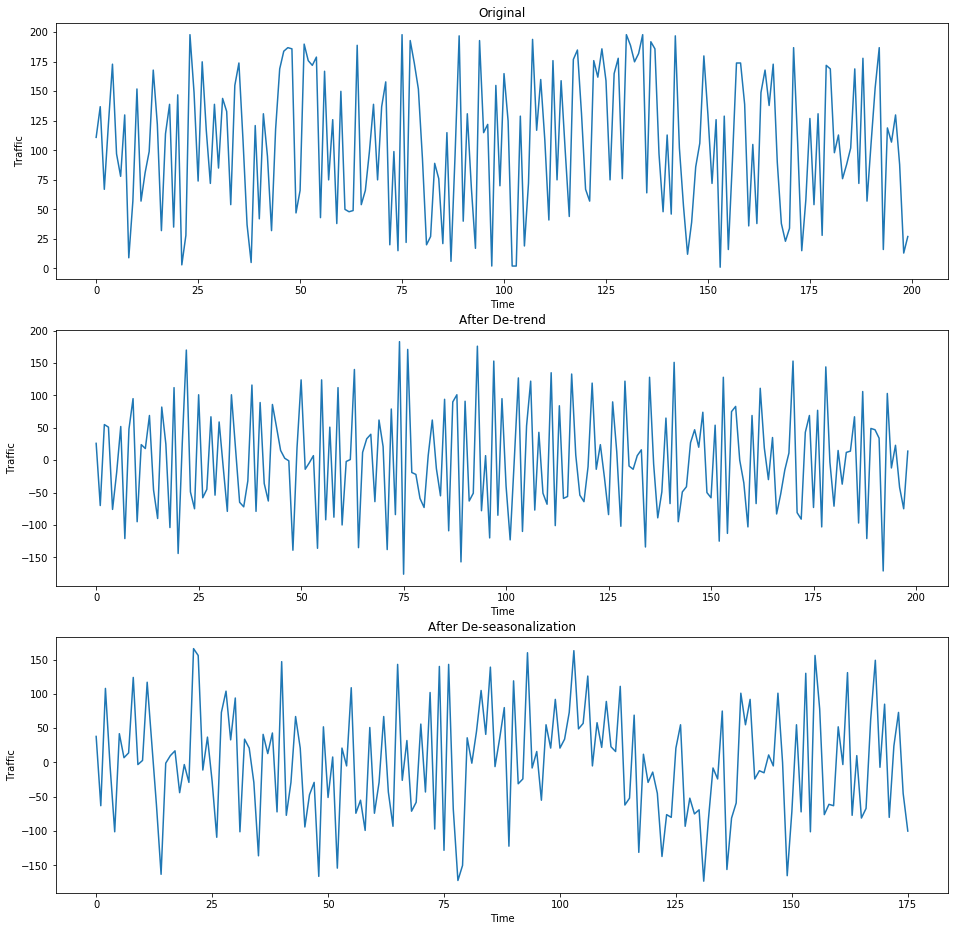

In [11]:
ts=df['y']
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Traffic')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Traffic')
new_ts=difference(ts,24)       # assuming the seasonality is 24 units long
plt.plot(new_ts)
plt.plot()

In [12]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -8.277322e+00
p-value                        4.618864e-13
#Lags Used                     1.000000e+00
Number of Observations Used    1.740000e+02
Critical Value (1%)           -3.468502e+00
Critical Value (5%)           -2.878298e+00
Critical Value (10%)          -2.575704e+00
dtype: float64


Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

We can easily get back the original series using the inverse transform function that we have defined above.

Now let's dive into making the forecasts!

### AR, MA and ARMA models

In [13]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [14]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 2046.12516 | order: (3, 2)


We use the code below to predict

In [15]:
best_mdl.predict()

array([  0.        ,  -1.45612143,   4.85387981,  -9.50157879,
         8.53582054,   2.85693511, -16.74706403,   8.71291324,
        12.25765922, -11.65527375,  -1.83981837,   0.42511368,
        -1.83140088,   9.08912164,  -3.07716389, -11.29439101,
        -7.68101543,  23.61766539,   7.77236877, -20.09908974,
       -13.14619254,  23.42560992,   4.04599472,  -7.8930322 ,
        -0.57418014,  -7.62470005,   6.36254447,   5.01525245,
       -18.32117359,   8.6441418 ,  22.02900779, -16.33400869,
        -9.87215726,  -4.48821235,  20.92591603,   4.89891879,
       -20.58729311, -19.40632713,  35.34546651,  15.43458154,
       -27.76046834, -31.85584684,  52.80653073,  10.63437875,
       -50.64708895,  -0.59457442,  49.40092109, -10.91589267,
       -44.97369195,  16.58848695,  24.0900616 ,   5.50127964,
       -34.21309181,   5.04277467,  12.95307586,  10.44040523,
       -18.68553908,   6.28975212,   1.95330758,  -3.59204398,
       -11.53790199,  20.51572486,  -1.24119785, -19.89

In [16]:
d1 = pd.DataFrame(pd.date_range(start = '2015-11-01 00:00:00',end='2015-11-09 07:00:00', freq = 'H'), columns = ['index'])

In [17]:
new_df = d1.join(df['y'], how='outer')

In [18]:
new_df

,index,y
0,2015-11-01 00:00:00,111
1,2015-11-01 01:00:00,137
2,2015-11-01 02:00:00,67
3,2015-11-01 03:00:00,122
4,2015-11-01 04:00:00,173
...,...,...
195,2015-11-09 03:00:00,107
196,2015-11-09 04:00:00,130
197,2015-11-09 05:00:00,88
198,2015-11-09 06:00:00,13


### Prophet

In [19]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [20]:
ts = new_df
ts.columns=['ds','y']

In [21]:
model = Prophet(changepoint_prior_scale= 0.3, growth= 'linear',yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [22]:
# 14592
# 2952
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 168, freq = 'H')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
358,2015-11-15 22:00:00,71.740763,3.367405,146.382386
359,2015-11-15 23:00:00,62.911952,-4.480026,135.777413
360,2015-11-16 00:00:00,40.407617,-32.497957,110.726437
361,2015-11-16 01:00:00,23.114730,-51.982060,92.240202
362,2015-11-16 02:00:00,26.704959,-46.894534,99.753406
363,2015-11-16 03:00:00,48.506080,-20.186731,123.488134
364,2015-11-16 04:00:00,68.950336,-5.266659,141.446800
365,2015-11-16 05:00:00,68.902948,-3.257100,146.933161
366,2015-11-16 06:00:00,46.931999,-15.787223,119.164111
367,2015-11-16 07:00:00,20.448713,-46.550703,93.986534


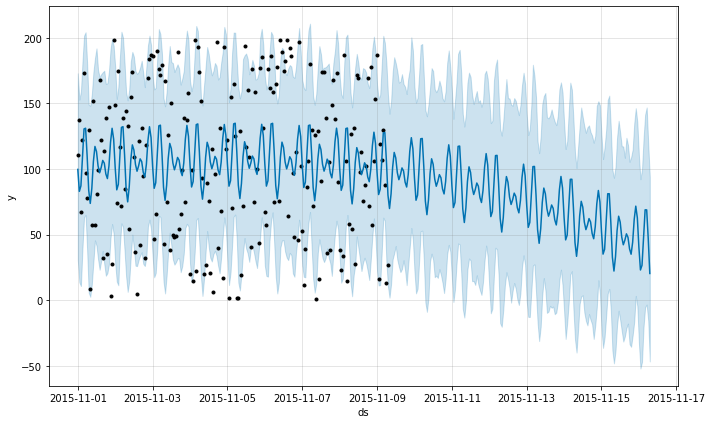

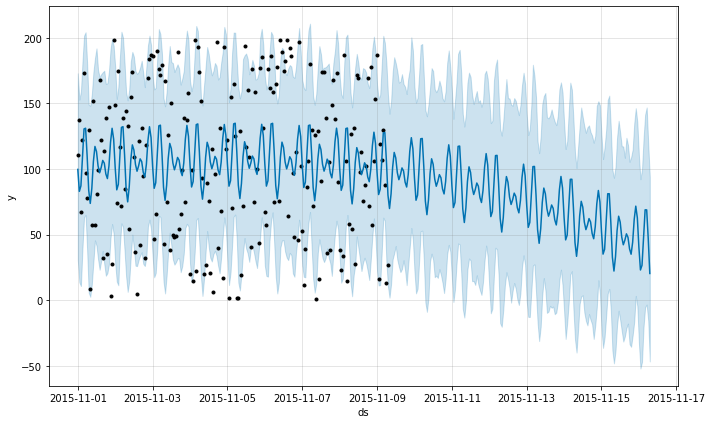

In [23]:
model.plot(forecast)

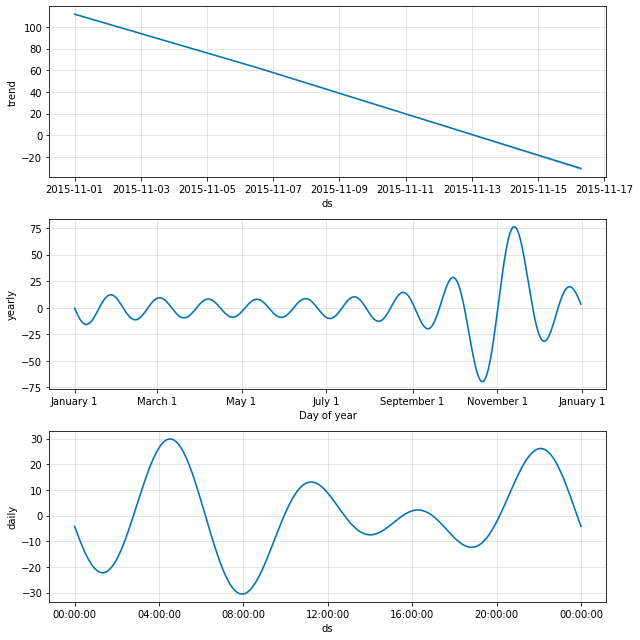

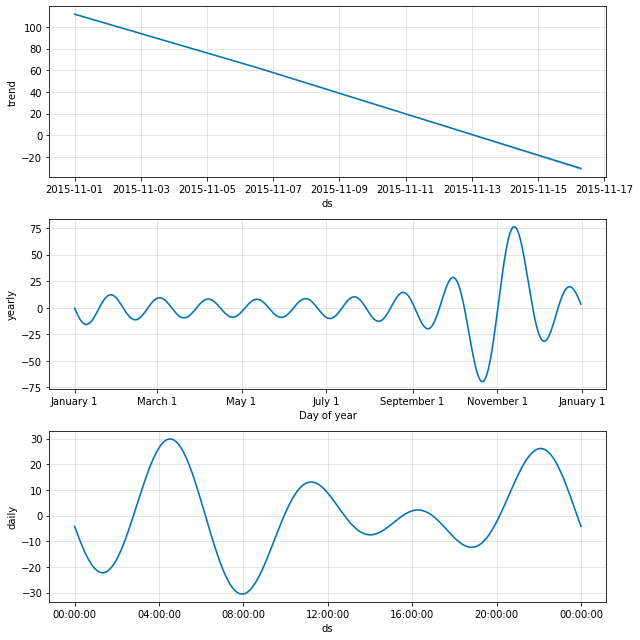

In [24]:
model.plot_components(forecast)

## References

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts